### Notebook for analysing nf pipeline output

#### Sequencing batch three "a" and "b", and batch 4
 - A: sequenced on the NextSeq_01-04-2021
 - B: sequenced on MiSeq_09-04-2021
 - Batch 4: MisSeq_

<ipython-input-5-ea9428a3bdb2>:28: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()


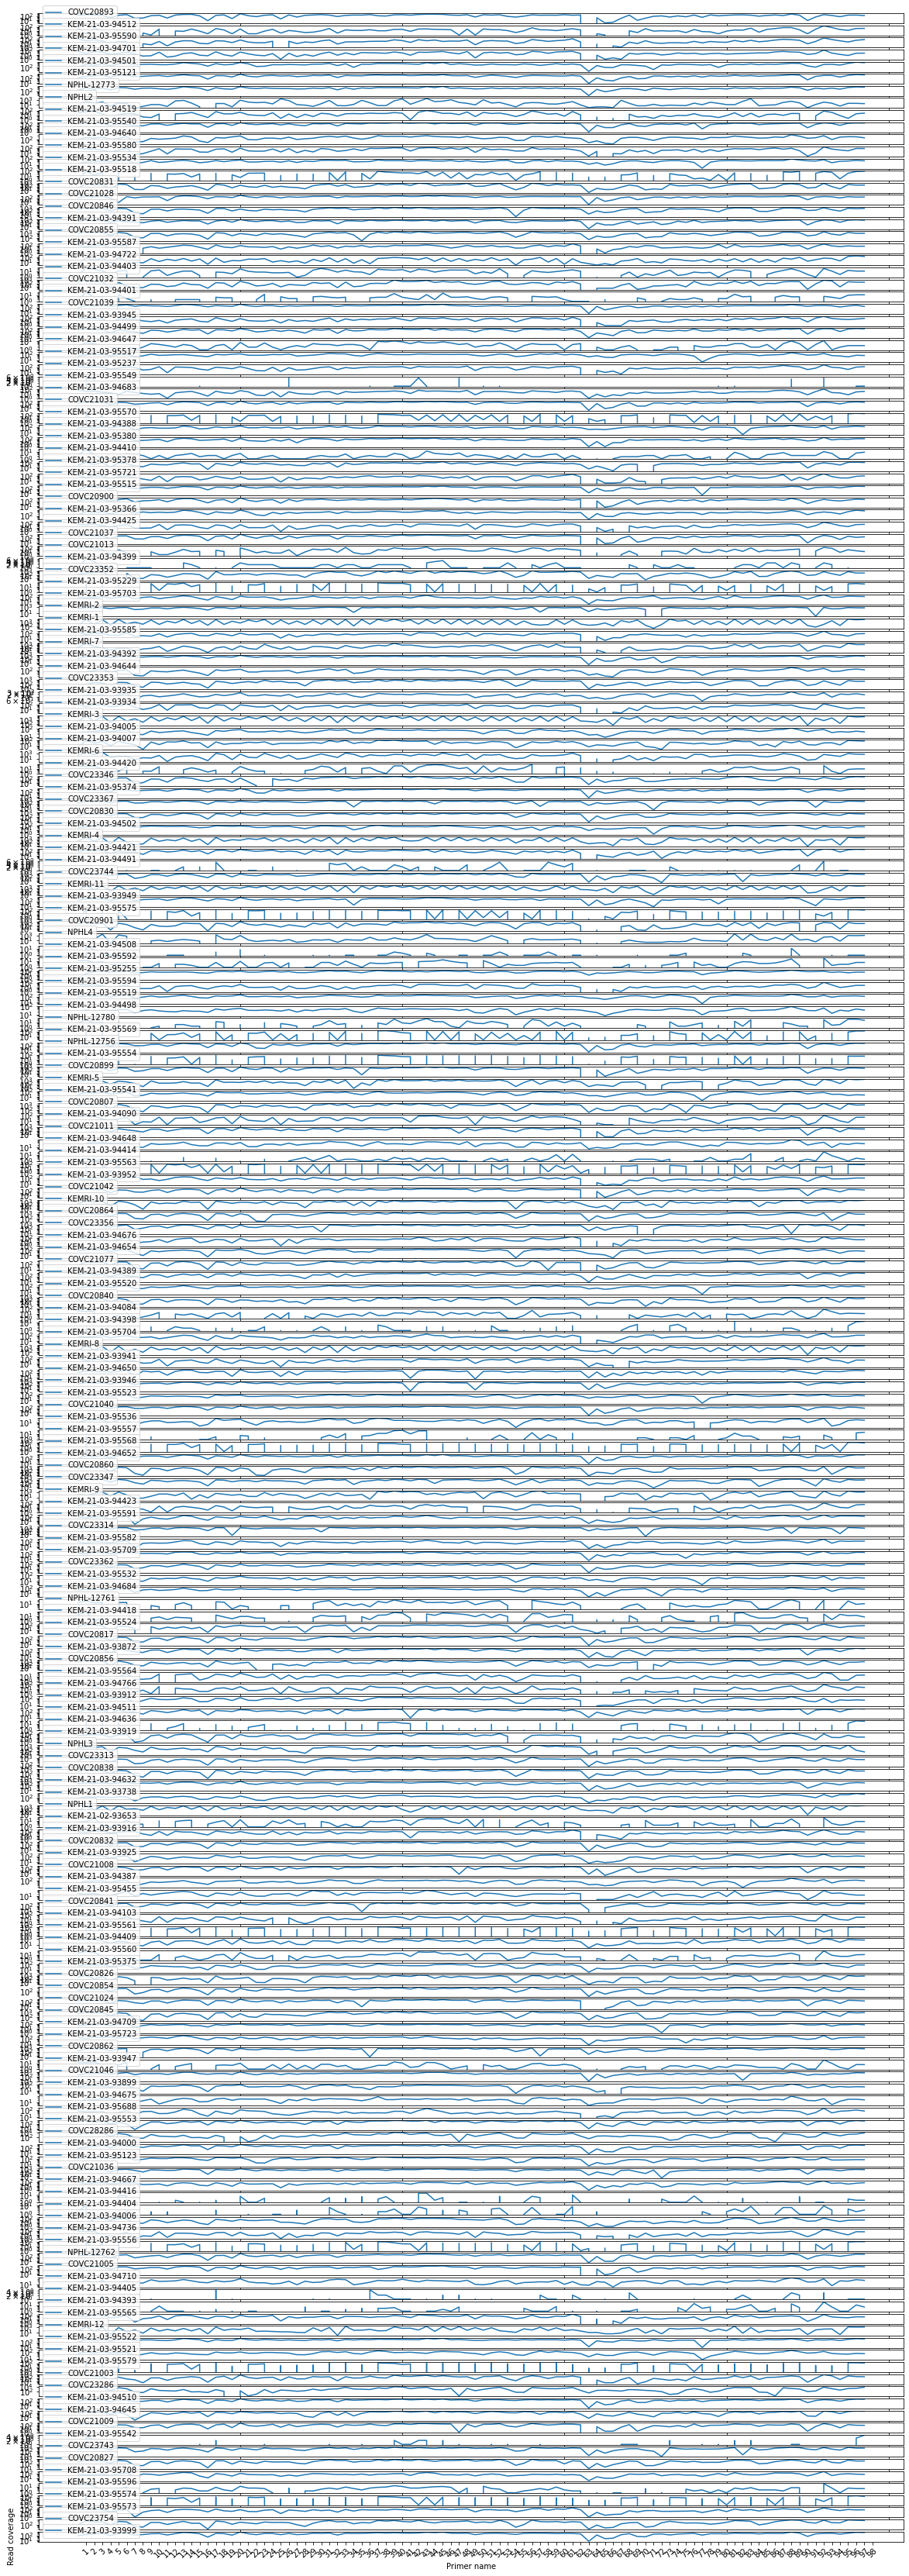

In [5]:
# plot primer depths across samples-GK
import pandas as pd, matplotlib.pyplot as plt, numpy as np, os

suffix = '.amplicon.regions.coverage.tsv'
base_dir = '/home/douso/Kibet/merged/dpt'
files = os.listdir(f'{base_dir}')
data = []
for file in files:
    if file.endswith(suffix):
        data.append(file)
    else: pass
a = len(data)
b, c = 1, -1
fig, axs = plt.subplots(a, b, figsize=(20,60)) 

xtick = np.arange(1, 99)

for file in data:
    c += 1
    sample_name = file.split('_')[0]
    sample_df = pd.read_table(f'{base_dir}/{file}')
    sample_df2 = sample_df[['region', 'coverage']]
    sample_df2.plot(logy=True, ax=axs[c], sharex=True, sharey=False) 
    axs[c].legend([sample_name], loc='lower left')
plt.xlabel('Primer name')
plt.ylabel('Read coverage')
plt.xticks(xtick, rotation=45)
plt.tight_layout()
plt.show()
#fig.savesample_df2fig('avg_kit_coverage2.png')


<ipython-input-6-dc4e9e7c151f>:33: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()


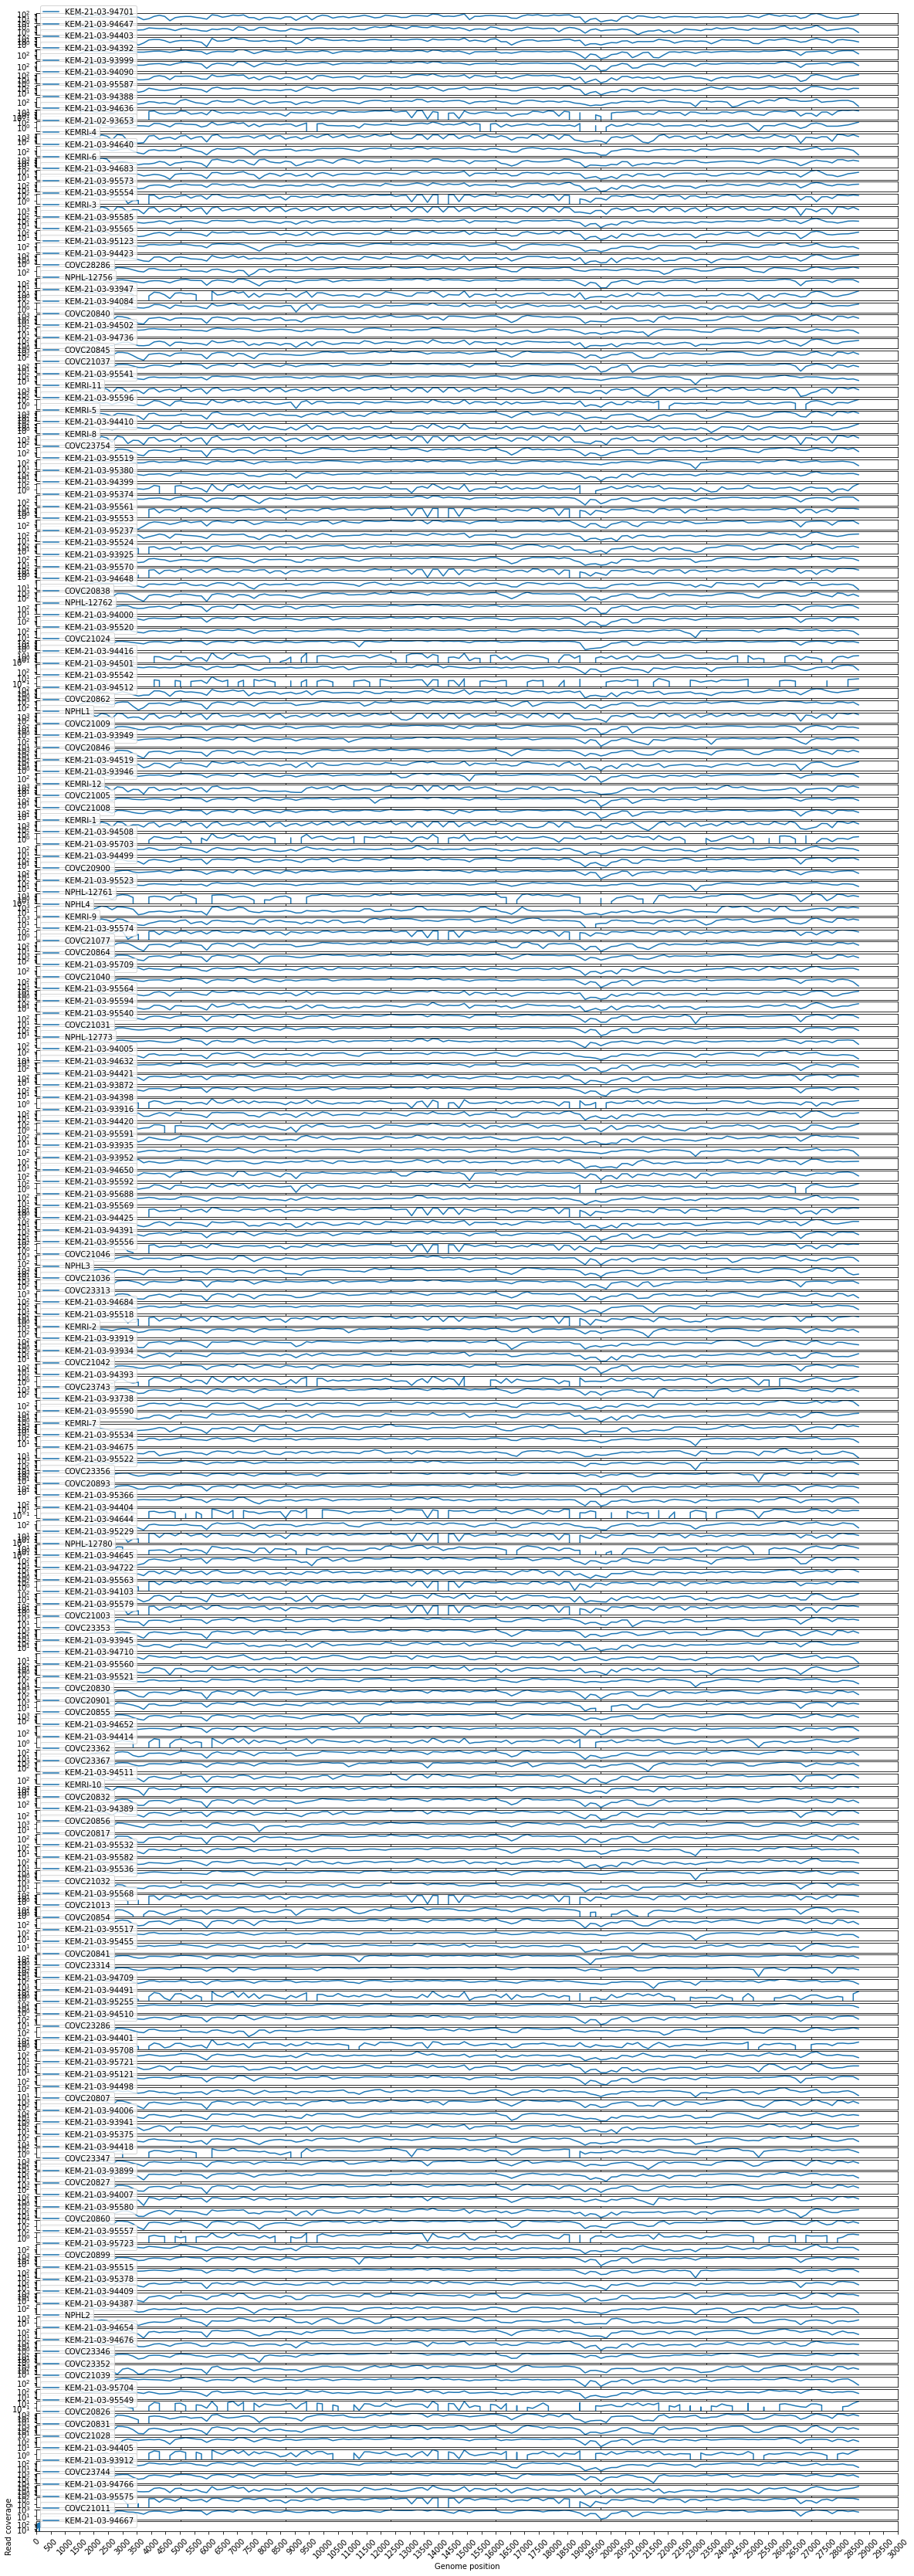

In [6]:
# plot read depths-GK
import pandas as pd, numpy as np, os, matplotlib.pyplot as plt

suffix = '.genome.regions.coverage.tsv'
base_dir = '/home/douso/Kibet/merged/dpt'
files = os.listdir(f'{base_dir}')
data = []
for file in files:
    if file.endswith(suffix):
        data.append(file)
    else: pass
a = len(data)
b, c = 1, -1

fig, axs = plt.subplots(a, b, figsize=(20, 60))

xtick = np.arange(0, 30500, 500)

for file in data:
    c += 1
    sample_name = file.split('_')[0]
    try:
        df1 = pd.read_table(f'{base_dir}/{file}')
        df1['coverage'].plot(logy=True, ax=axs[c], sharex=True)
        axs[c].legend([sample_name], loc='lower left')
        text = file.split('_')[1]
        plt.ylabel('Read coverage')
    except TypeError:
            print(f'no numeric data to plot for {file}')
    finally: pass
plt.xlabel('Genome position')
plt.xticks(xtick, rotation=45)
plt.tight_layout()
plt.show()
#fig.savefig('avg_kit_coverage.png')

## Packages

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import regex as re

In [8]:
base_dir = '/home/douso/Kibet/merged'
batch = '3-4'
# dpt_dir = # ivar, samtools-depth output files
# nxt_dir = # nextclade .tsv output file
# png_dir = # pangolin .tsv output file
# var_dir = # snpEff ouput
# rmd_dir = # raw metadata - moh .xlsx spread sheet
#dpt var nxt png

## Analysis of batch 3 and 4 
### Sequencing information 
 - Analysis no.: NF-001 (batch 3 & 4)
 - Platform: Illumina NextSeq; MiSeq
 - Library preparion: NEBNext (M-FS)
 - Seq Date: NextSeq (09-04-2021); MiSeq (19-04-2021; month 21-04-2021)
 - Number of samples: 33
 - Sample summ: COVCs and NPHL
 - VC pipeline: nextflow-viralcon

## Functions

In [9]:
# define a func to replace spaces in the header names
def tidy_header(df):
    df.columns = [col.replace(' ', '_') for col in df.columns]
    return df

In [10]:
# define func to retrieve particular columns from a df (spaces in col names must be replaced with _ in the input col_list)
def get_cols(df, col_list):
    new_df = tidy_header(df)
    return new_df[col_list]

In [11]:
# define a function to replace from a dictionary ('key is what is to be replaced': 'value is the replacement')
def replace(string, substitutions):
    substrings = sorted(substitutions, key=len, reverse=True)
    regex = re.compile('|'.join(map(re.escape, substrings)))
    return regex.sub(lambda match: substitutions[match.group(0)], string)

In [12]:
# define function to merge variants and nextclade data
def merge_varNxt(df_var_cln, df_nxt_cln):
    return (df_var_cln.set_index('sample_name').merge(df_nxt_cln
          .set_index('seqName'), how='outer', left_index=True, right_index=True)
                 .reset_index().rename(columns={'index': 'sample_name'}))

In [13]:
# define function to merge pangolin and variants-nextclade data
def merge_pngVxt(df_png_cln, df_varNxt):
    return (df_png_cln.set_index('Sequence_name').merge(df_varNxt
        .set_index('sample_name'), how='outer', left_index=True, right_index=True)
            .reset_index().rename(columns={'index': 'Sequence_name'}))


In [14]:
# define function to merge metadata with cts data
def merge_rmdCts(df_rmd_cln, df_cts_cln):
    return (df_rmd_cln.merge(df_cts_cln, left_on='Sample_No', right_on='Sample_Name')
            .drop('Sample_Name', axis=1))


In [15]:
# define function to merge metadata and seq data
def merge_vnpPmd(df_pngVxt, df_rmdCts):
    return (df_pngVxt.set_index('Sequence_name')
            .merge(df_rmdCts.set_index('Sample_No'), how='left', left_index=True, right_index=True)
                 .reset_index().rename(columns={'index': 'Sequence_name'}))

In [16]:
# define a function to retrieve MoC and all mutations for the s-gene
def get_mut_of_concern(ann_file_name, moc_list):

    def intersection(x, y):
        return list(set(x) & set(y))

    moc_list = moc_list
#     file_name = 'k-per-gene_variant_anns.tsv'
    df = ann_file_name[['sample_name','S']]

#     df = pd.read_table(f'{base_dir}/{file_name}')[['sample_name','S']]
    mutations = []
    moc = []
    sample_id = []
    for row in df.itertuples():
        substitutions = row.S.replace(' ', '').split(',')[1:-1]
        if len(moc_list) >= len(intersection(moc_list, substitutions)) > 0:
            intsct = intersection(moc_list, substitutions)
            sample_name = row.sample_name
            mutations.append(str(substitutions).replace("[", "").replace("]", "").replace("'", ""))
            moc.append(str(intsct).replace("[", "").replace("]", "").replace("'", ""))
            sample_id.append(sample_name)
        else: pass 
    df = pd.DataFrame({'Sample_ID': sample_id, 'Mut_of_Concern_(S)': moc, 'All_Mutations_(S)': mutations})
    df_fnl = df.assign(Sample_ID = df['Sample_ID'].apply(lambda x: x.split('_')[0]))
    return df_fnl

### Variants data

In [17]:
# import the collated file for all the snpEff outputs
df_var = pd.read_table(f'{base_dir}/var/k-per-gene_variant_anns.tsv')
df_var_fnl = df_var.assign(sample_name = df_var['sample_name'].apply(lambda x: x.split('_')[0]))

FileNotFoundError: [Errno 2] No such file or directory: '/home/douso/Kibet/merged/var/k-per-gene_variant_anns.tsv'

In [ ]:
df_var_fnl.head()

### Nextclade data

In [ ]:
# import Nextclade clade data
df_nxt = pd.read_table(f'{base_dir}/nxt/NPHL_COVC_con.tsv')

# retrieve cols seqName and clade (func get_cols replaces col name spaces with _)
cols = ['seqName', 'clade', 'totalMissing']
df_nxt_cln = get_cols(df_nxt, cols)
coverage = round(100 - (df_nxt_cln['totalMissing'] / 29903) * 100, 1)
df_nxt_cln1 = df_nxt_cln.assign(seqName = df_nxt_cln['seqName'].apply(lambda x: x.split('_')[0]))
df_nxt_fnl = df_nxt_cln1.assign(coverage = coverage).drop('totalMissing', axis=1)

In [ ]:
df_nxt_fnl.head()

### Pangolin data

In [ ]:
# import Pangolin lineage data
df_png = pd.read_csv(f'{base_dir}/png/run3_run4_Over90_con_manual.aln_pango_results.csv', header=0)
# base_dir_pango = '/home/ouso/nextclade_files/batch2/nextclade_files_04-04-2021_11:25'
# file_name_pango = 'consensus_pango.xlsx'

# df_png = pd.read_excel(f'{base_dir_pango}/{file_name_pango}')
months = {'January': 'Jan', 'February': 'Feb', 'March': 'Mar',
         'April': 'Apr', 'June': 'Jun', 'July': 'Jul', 'August': 'Aug',
          'September': 'Sep', 'October': 'Oct', 'November': 'Nov', 'December': 'Dec'}
# retrieve cols Sequence_name and Lineage (func get_cols replaces col names spaces with _)
cols = ['Sequence_name', 'Lineage', 'Date_range', 'Most_common_countries']
df_png_cln = get_cols(tidy_header(df_png), cols)
df_png_cln1 = df_png_cln.assign(Sequence_name = df_png_cln['Sequence_name'].apply(lambda x: x.split('_')[0]))
df_png_fnl = df_png_cln1.assign(Date_range=df_png_cln1['Date_range'].apply(lambda x: replace(x, months)))

In [ ]:
df_png_fnl.head()

# Metadata

In [ ]:
# import raw metadata file
import pandas as pd
mbase_dir = '/home/ouso/Insync/D.Ouso@cgiar.org/OneDrive Biz/sequencing_metadata/raw'
df_rmd = pd.read_excel(f'{mbase_dir}/Sequencing_metadata_merged_raw.xlsx')

In [ ]:
df_rmd.head()

In [ ]:
cols = ['Sample_No', 'Age', 'Age_Unit', 'Gender', 'Occupation'
         , 'Nationality', 'County_of_Residence', 'Has_travel_History'
         , 'Travel_from', 'Quarantine_facility', 'Have_symptoms'
         , 'Date_of_Onset_of_symptoms', 'Symptoms_shown', 'Sample_Type'
         , 'Date_of_Sample_Collection','Date_Sample_Received_in_the_lab'
        , 'Result', 'Lab_confirmation_date']
df_rmd_cln = get_cols(tidy_header(df_rmd), cols)

In [ ]:
df_rmd_cln.head()

### Ct data

In [ ]:
# import Ct data from sheet2 of the metadata file
df_cts = pd.read_excel(f'{mbase_dir}/Sequencing Samples_Batch 3.xlsx', 'Combined Data', header=1)

In [ ]:
# cols = ['Sample_Name', 'Average_Ct']
# df_cts_cln = get_cols(tidy_header(df_cts), cols)
# df_cts_fnl = df_cts_cln.assign(Sequence_name = df_cts_cln['Sequence_name'].apply(lambda x: x.split('_')[0]))

In [ ]:
# df_cts_cln.head()

In [ ]:
df_cts = get_cols(df_cts, ['Sample_Name', 'Average_Ct'])
##############
df_cts = df_cts.assign(Sample_Name = df_cts['Sample_Name'].apply(lambda x: 'COVC' + str(x)))# special case for this batch 
#to correct sample name
##############
df_cts.head()

### Combining data

#### Merge Variants and Nextclade data

In [ ]:
# merge the nextclade data to the pangolin data
df_varNxt = merge_varNxt(df_var_fnl, df_nxt_fnl)

In [ ]:
df_varNxt.head()

#### Merge pango and var-nextclade data

In [ ]:
# merge the variants-nextclade data to the pangolin data (prioritise pango - left join)
df_pngVxt = merge_pngVxt(df_png_fnl, df_varNxt)

In [ ]:
df_pngVxt.head()

#### Merge the metadata and Cts data

In [ ]:
# merge metadata with cts data
df_rmdCts = merge_rmdCts(df_rmd_cln, df_cts)

In [ ]:
df_rmdCts#.head()

In [ ]:
df_rmdCts['Date_Sample_Received_in_the_lab'].value_counts()

#### Merge sequence/var-nxt-png (pngVxt) and  processed metadata (rmdCts)

In [ ]:
# merge processed metadata with seq data
df_vnpPmd = merge_vnpPmd(df_pngVxt, df_rmdCts)

In [ ]:
df_vnpPmd.head()

#### QC whether all samples sequenced had metadata

In [ ]:
codes_fnl = set(df_vnpPmd['Sequence_name'])
codes_metadata = set(df_rmdCts['Sample_No'])
codes_union = codes_fnl & codes_metadata
if codes_fnl - codes_union == {}:
    print('All the samples in the the analysis were in the pre-seq metadata')
else:
    print(f'The following samples may be lacking pre-seq metadata, please verify:\n{codes_fnl - codes_union}')
    

These samples codes were in the metadata and in the sequence data but somehow were not merging right (unexpected NA cols)
 - COVC23743
 - COVC23286
 - COVC23744
 
These sample codes were in the sequencing data but not on the metadata. While NPHL3 didn't have metadata, COVC23754 
had metadata that was not captured in the sequencing metadata sheet.
 - COVC23754
 - NPHL3

Introduced a QC step (up) to captire such in the future

#### Re-order df_vnpPmd columns and export merged metadata and sequencing data

In [2]:
df_vnpPmd.columns

NameError: name 'df_vnpPmd' is not defined

In [44]:
header = ['Sequence_name', 'Age', 'Age_Unit', 'Gender'
          , 'Occupation', 'Nationality', 'County_of_Residence', 'Has_travel_History'
          , 'Travel_from', 'Quarantine_facility','Symptoms_shown'
          , 'Date_of_Sample_Collection', 'Date_Sample_Received_in_the_lab'
          , 'Result', 'Lab_confirmation_date', 'Average_Ct', 'Lineage'
          , 'Most_common_countries', 'Date_range', 'clade','coverage'
          , 'num_vars', 'S',  'ORF1ab', 'ORF1a', 'ORF3a', 'ORF3b', 'E'
          , 'M', 'ORF6', 'ORF7a', 'ORF7b', 'ORF8', 'N', 'ORF9a', 'ORF9b', 'ORF10']

In [45]:
cols_rename = ['S_NUM', 'AGE', 'AGE_UNIT', 'GEND', 'OCCU', 'NAT', 'COUNT_RES', 'TRAV_HIST',
               'TRAV_FROM', 'QUAR_PLACE', 'SYMPS', 'DT_SAM_COLL', 'DT_SAM_RECEP', 'RESULT', 
               'DT_CONF', 'AVG_Ct', 'LIN', 'M_COMM_C', 'DT_RANG', 'CLADE', 'G_COV', 'N_VAR',
               'S', 'ORF1ab', 'ORF1a', 'ORF3a', 'ORF3b', 'E', 'M', 'ORF6', 'ORF7a', 'ORF7b', 
               'ORF8', 'N', 'ORF9a', 'ORF9b', 'ORF10']

In [46]:
header_policy = ['Sequence_name', 'Age', 'Age_Unit', 'Gender'
          , 'Occupation', 'Nationality', 'County_of_Residence', 'Has_travel_History'
          , 'Travel_from', 'Quarantine_facility', 'Have_symptoms'
          , 'Date_of_Onset_of_symptoms', 'Symptoms_shown', 'Sample_Type'
          , 'Date_of_Sample_Collection', 'Date_Sample_Received_in_the_lab'
          , 'Result', 'Lab_confirmation_date', 'Average_Ct']

In [ ]:
df_vnpPmd_fnl = df_vnpPmd[header]
df_vnpPmd_fnl.columns = cols_rename
df_vnpPmd_fnl.to_excel('/home/douso/Insync/D.Ouso@cgiar.org/OneDrive Biz/sequencing_metadata/processed/seq-metadata-SM002.xlsx'
                     , index=False, na_rep='NA', float_format='%.1f')
df_vnpPmd_fnl.head()

### Variants of Concern or under investigation
 - N501Y (B.1.1.7): UK variant
 - N501Y, E484K, *K417N (B.1.351): SA variant
 - N501Y, E484K (P.1): Brazilian variant
 - P681R, E484Q, L452R (B.1.617): *Indian variant

In [ ]:
# MOH mutations of concern (spike only)
moc_list = ['N501Y', 'E484K', 'K417N', 'P681R', 'E484Q', 'L452R', 'A570D', 'D80A']
file_name = df_var_fnl
df_moc = get_mut_of_concern(file_name, moc_list)

In [ ]:
df_moc.head()

### Subsample brief data

In [ ]:
df_vnpPmd.columns

In [ ]:
#reorder columns and shrink data
cols = ['Sequence_name','Date_Sample_Received_in_the_lab', 'Lineage', 'clade', 'County_of_Residence'
        , 'Gender', 'Nationality']

In [ ]:
df_brief = df_vnpPmd[cols]

In [ ]:
df_brief.head()

#### Merge df_brief with df_moc

In [ ]:
df_brfMoc = (df_brief.merge(df_moc, how='left', left_on='Sequence_name', right_on='Sample_ID'))
df_brfMoc_cln = (df_brfMoc.assign(Date_Sample_Received_in_the_lab=df_brfMoc['Date_Sample_Received_in_the_lab']
                                                .map(lambda x: x.strftime(format='%d-%m-%Y'), na_action='ignore')))
df_brfMoc_cln1 = (df_brfMoc_cln.assign(Date_Sample_Received_in_the_lab=df_brfMoc['Date_Sample_Received_in_the_lab']
                                       .map(lambda x: x.strftime(format='%d-%m-%Y'), na_action='ignore')))
                                       #.apply(lambda x: pd.to_datetime(x, format='%d-%m-%Y', errors='coerce'))))
df_brfMoc_fnl = (df_brfMoc_cln1.fillna('NA')
                 .loc[df_brfMoc_cln1['Sequence_name'] != 'Undetermined']# removes "undetermined"
                 .drop(['Sample_ID', 'All_Mutations_(S)'], axis=1))

In [ ]:
df_brfMoc_fnl['Date_Sample_Received_in_the_lab'].value_counts()

In [ ]:
df_brfMoc_fnl

### Policy brief report

In [ ]:
#df_report = df_brfMoc_fnl.drop(['Sequence_name'], axis=1)

In [ ]:
df_brfMoc_fnl.columns

In [ ]:
df_brfMoc_fnl.head()

#### Rename report columns

In [ ]:
cols = ['Sequence Name', 'Date Received (dd-mm-yyyy)', 'Pango Lineage Annotation', 'Next Clade Lineage Annotation', 'Sample County of Origin', 'Gender', 'Patient Country of Origin', 'MoC-S-Protein']
df_brfMoc_fnl.columns = cols
#brief_moc_data.fillna('N/A').to_excel('/home/ouso/Insync/D.Ouso@cgiar.org/OneDrive Biz/sequencing_metadata/processed/Policy_Brief-001.xlsx')
df_report_fnl = df_brfMoc_fnl.sort_values('Date Received (dd-mm-yyyy)')

In [ ]:
df_report_fnl.fillna('N/A').to_excel('/home/ouso/Insync/D.Ouso@cgiar.org/OneDrive Biz/\
sequencing_metadata/processed/policy-brief-T002.xlsx', index=False)

In [ ]:
(df_report_fnl['Sample County of Origin']
 .value_counts())

In [ ]:
#clrs = pd.read_html('https://www.rapidtables.com/web/css/css-color.html')

In [ ]:
df_report_fnl.head()

In [ ]:
# plot lineage frequencies
colors = ['#00FFFF', '#FFA500', '#808080'
          ,'#A52A2A', '#FF0000', '#008000'
          , '#4B0082', '#008080']
n = df_report_fnl['Pango Lineage Annotation'].count()
fig, ax = plt.subplots()
(df_report_fnl['Pango Lineage Annotation']
 .value_counts()
 .plot(kind='bar', ax=ax, color=colors))
plt.title('Lineage frequencies')
plt.xlabel('Lineages')
plt.xticks(rotation=45)
plt.ylabel(f'No. of samples (n = {n})')
plt.tight_layout()
#fig.savefig('/home/ouso/Insync/D.Ouso@cgiar.org/OneDrive Biz/sequencing_metadata/processed/policy_brief-P002.png', dpi=300.0)
plt.show()